# Notebook  7 - Dinamica Molecolare NVT

Questa lezione contiene la stessa simulazione del Notebook 4 (108 molecole di Argon), ma viene condotta nell'ensemble canonico e mira a correggere alcuni difetti della precedente simulazione.

   - [  7.1 - Tail Corrections ](#ex-7.1) 
   
   - [  7.2 - Studio dell'Autocorrelazione ](#ex-7.2)
   
   - [  7.3 - Funzione di Distribuzione Radiale ](#ex-7.3)
   
   - [  7.4 - Confronto NVE - NVT ](#ex-7.4)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

<a id="ex-7.1"></a>
## Esercizio 7.1. - Tail Corrections
Come già accennato nel Notebook 4, l'introduzione di un raggio di cutoff nell'algoritmo, necessaria per non estendere la sommatoria a tutte le particelle presenti, comporta che vengano trascurate alcune interazioni durante il calcolo delle quantità richieste. Attraverso la <i> funzione di distribuzione radiale</i>, che viene discussa nel paragrafo [7.3](#ex-7.3), è possibile dimostare che queste <i> tail correction </i> per un potenziale di Lennard-Jones corrispondono a:

\begin{equation}
    \frac{U_{tail}}{N} = \frac{8 \pi \rho\epsilon}{9r^9_{c}} - \frac{8 \pi \rho\epsilon}{3r^3_{c}}
\end{equation}

\begin{equation}
    \frac{P_{tail}}{3N \epsilon} = 32 \pi \rho \left[ \frac{1}{9r^9_c} - \frac{1}{6r_c^3}\right]
\end{equation}

Dove $\epsilon, \rho$ sono le costanti presenti all'interno del potenziale di Lennard Jones. Prima di procedere con le simulazioni di questo esercizio, tali correzioni sono state aggiunte al codice. 

<a id="ex-7.2"></a>
## Esercizio 7.2. - Studio dell'Autocorrelazione
### Equilibrazione
Mentre nel Notebook 4 il sistema veniva fatto evolvere nell' <b> ensemble microcanonico </b>, dove l'energia totale era fissata, in questo notebook ci muoveremo principalmente all'interno dell' <b> ensemble canonico ($NVT$) </b>, dove ad essere fissati sono:
1. Numero di particelle `N = 108`
2. Volume `V`
3. Temperatura `T`

Per questo motivo, non è più stato necessario partire da una temperatura diversa da quella di equilibrio e aspettare la termalizzazione, ma si sono inserite nel file `input.dat` le temperature di equilibrio (e densità) seguenti.
- Stato solido: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- Stato liquido: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- Stato gassoso: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

Un'ulteriore differenza rispetto al notebook 4 è stata nel metodo `Move()`, che non utilizza più l'algoritmo di Verlet ma quello di Metropolis. </br>
Nonostante l'equilibrazione della temperatura non sia più necessaria, è ora l'energia potenziale ad oscillare attorno ad un valore di equilibrio, motivo per il quale si è studiato il tempo di equilibrazione per i tre stati.

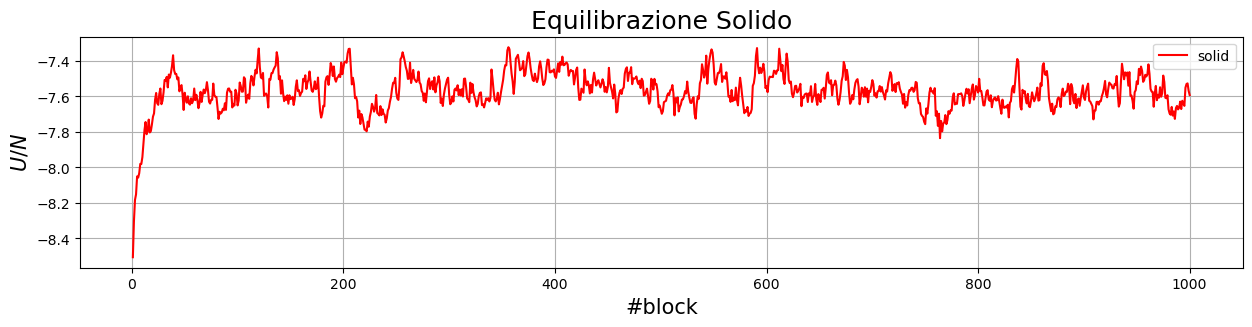

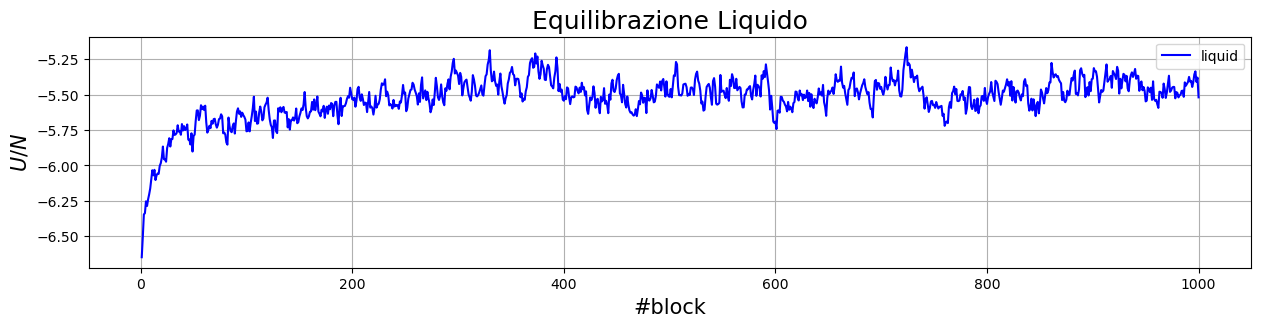

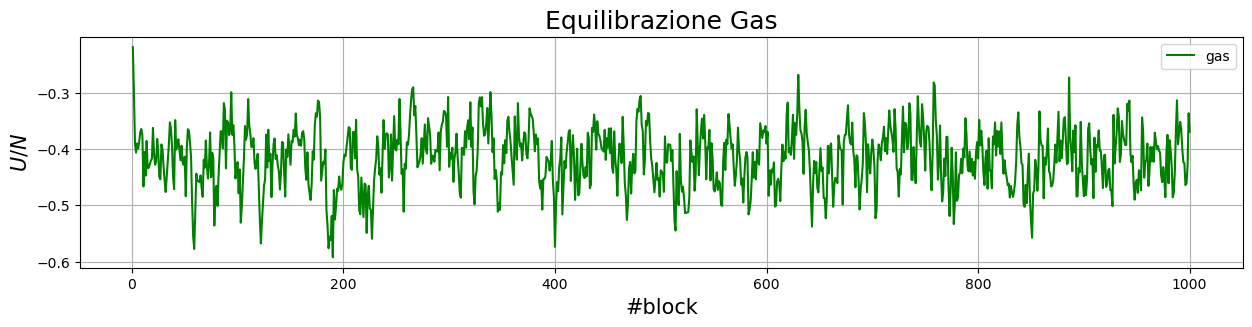

In [2]:
title = ['Solido', 'Liquido', 'Gas']
state = ['solid', 'liquid', 'gas']
color = ['red', 'blue', 'green']

for i in range(0,3):
    x, aveT = np.loadtxt("Exercise07-1/output/therma/output_epot_"  + state[i] + ".dat", usecols=(0, 1), delimiter='\t', unpack='true')
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(x, aveT, marker=None, label=state[i], color = color[i])
    ax.set_title("Equilibrazione " + title[i], fontsize=18)
    ax.set_ylabel(r'$U/N$', fontsize=15)
    ax.set_xlabel('#block', fontsize=15)
    ax.grid(True)
    ax.legend()
    plt.show()

Si nota che, a differenza della simulazione $NVE$, l'equilibrazione necessità di molto meno tempo e oscilla in maniera più contenuta, tanto che per $N=1000$ passi tutti e tre gli stati sembrano raggiungere una configurazione di equilibrio soddisfacente. Per i motivi già analizzati nella lezione 4, lo stato gassoso raggiunge sempre dei risultati meno soddisfacenti e meno stabili rispetto agli altri due.

### Autocorrelazione
L'autocorrelazione è una misura di quanto il sistema è correlato ad una copia futura di sé stesso. È fondamentale per il nostro studio perche gli step successivi di Metropolis saranno correlati, e di conseguenza è opportuno scegliere, nel data blocking, una dimensione dei blocchi tale da superare di molto il tempo di correlazione delle misure. In questo modo le medie a blocchi saranno davvero campioni indipendenti e si potrà procedere nell'analisi senza il timore che i dati siano inficiati dalla correlazione interna tra di loro. </br>
Si è quindi calcolata la funzione di autocorrelazione $\chi (n)$ in funzione del numero di step Metropolis, su un campione di $M = 5 \cdot 10^5$ dati. Ci si aspetta che la funzione di autocorrelazione abbia un decadimento esponenziale, ed è stata calcolata implementando la seguente formula nel seguente blocco di codice:

\begin{equation}
\chi(t) = \frac{1}{n_{max} - n}\frac{\sum_{n' = 0}^{n_{max} - n} m(n')m(n'+n) - \sum_{n' = 0}^{n_{max} - n}m(n')\sum_{n' = 0}^{n_{max} - n}m(n'+n)}{ \frac{1}{n_{max}} \sum_{n'=0}^{n_{max}} m^2(n') - \left( \frac{1}{n_{max}} \sum_{n'=0}^{n_{max}} m(n')\right)^2}
\end{equation}

Dove $n$ è il numero di step e $n_{max}$ il numero totale di misure. $m(n)$ è la funzione che si vuole valutare, nel caso di questo Notebook è l'energia interna del sistema $U$.


In [3]:
def autocorr(N,n,U):      #N numero totale, n numero di blocchi
    k=N/(N-n)
    somma1=0
    somma2=0
    somma3=0
    for i in range(N-n):
        somma1 = somma1 + U[i]*U[i+n]
        somma2 = somma2 + U[i]
        somma3 = somma3 + U[i+n]
    num = somma1-(somma2*somma3/((N-n)))
    somma4=0
    somma5 = 0
    for i in range(N):
        somma4 = somma4 + U[i]**2
        somma5 = somma5 + U[i]
    den = somma4 - somma5**2/(N)
    return k*num/den


Evaluating for solid state...
10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%, 

Evaluating for liquid state...
10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%, 

Evaluating for gas state...
10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, 100%, 



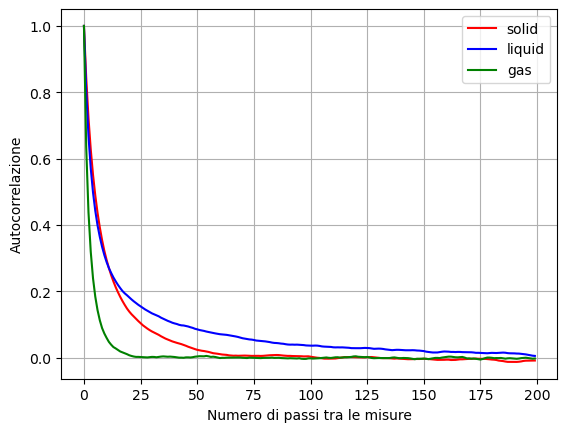

In [4]:
N = 500000
n = 200

U_g = U_l = U_s = []
U = [U_g, U_l, U_s]

for j in range(0,3):
    print("Evaluating for " + state[j] + " state...")
    k = 10
    chi = []
    U[j] = np.loadtxt("Exercise07-1/output/autocorr/autocorr_epot_"  + state[j] + ".dat", usecols=(1), delimiter='\t', unpack='true')
    for i in range(n):
        chi.append(autocorr(N, i, U[j]))
        if i%20 == 0:
            print(str(k) + "%", end= ", ")
            k += 10
    print('\n') 
    plt.plot(chi, color = color[j], label = state[j])
    plt.xlabel("Numero di passi tra le misure")
    plt.ylabel("Autocorrelazione")
plt.legend()
plt.grid()

Come previsto, per ogni stato il decadimento è esponenziale e anche molto rapido, per cui già con $100$ step per blocco si può affermare con certezza che il tempo di autocorrelazione viene ampiamente superato. Il motivo fondamentale per cui il tempo di autocorrelazione deve essere abbattuto è che l'errore, calcolato su misure tra loro correlate, verrebbe sottostimato. Per selezionare quindi la misura ottimale di $L=M/N$ è stato calcolato l'errore sul set di misure, per un range da $L=10$ a $L=5000$. I risultati vengono mostrati nei grafici sottostanti. </br>
La formula utilizzata per l'errore è la deviazione standard calcolata secondo il data blocking, come generalmente fatto nei codici C++ e spiegato nel Notebook 1.

In [5]:
def Error(ave, ave2, n):
    if(n==0): 
        return 0
    return np.sqrt((ave2-ave**2)/n)

def dataBlocking(x, N, L):
    mean=0
    mean2=0
    error=0
    for n in range(N):
        mean_block=0
        for l in range(L):
            mean_block+=x[l+n*L]
        mean_block/=L
        mean=(mean*n+mean_block)/(n+1)
        mean2=(mean2*n+mean_block**2)/(n+1)
        error=Error(mean, mean2,n)
    return error

Evaluating for solid state...
10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%,  100%

Evaluating for liquid state...
10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%,  100%

Evaluating for gas state...
10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%,  100%



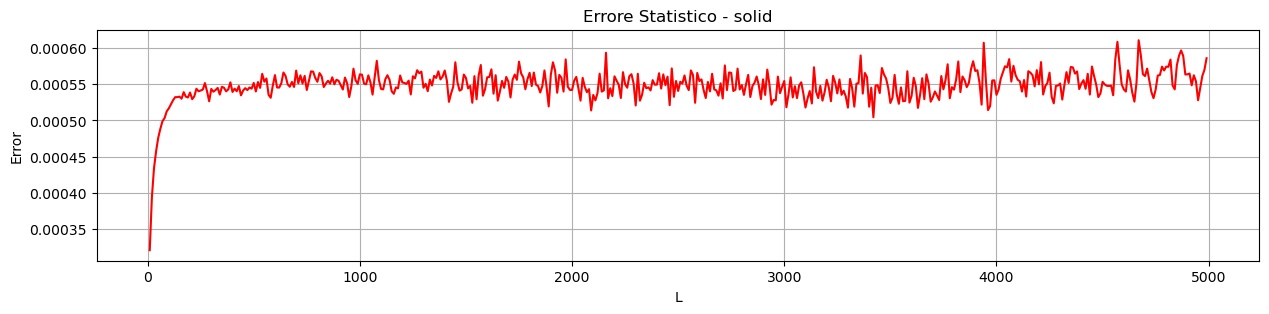

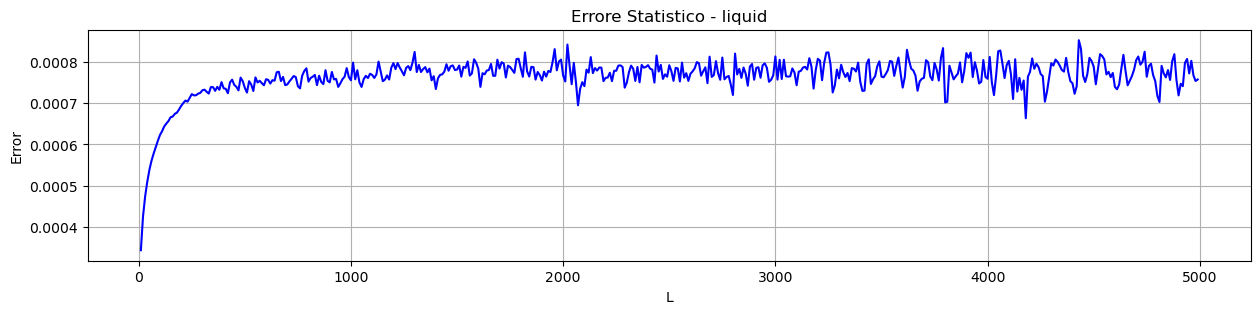

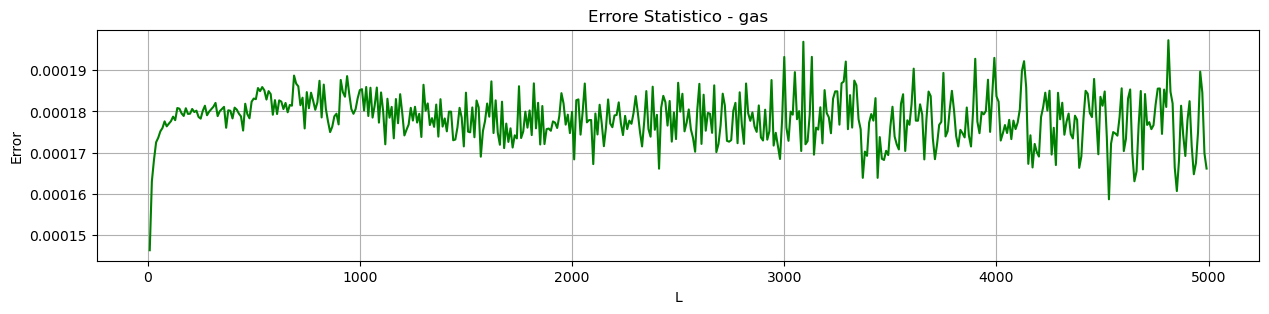

In [6]:
L_m=10
L_M=5000
M=500000

for i in range(0,3):
    
    plt.figure(figsize=(15, 3))
    plt.title("Errore Statistico - "+ state[i])
    y=U[i]
    error=[]
    x=[]
    L_range = range(10,5000, 10)
    k = 10
    print("Evaluating for " + state[i] + " state...")
    for L in L_range: 
        if L%500==0:
            print(str(k) + "%", end = ", ")
            k += 10
        N=int(M/L)
        err=dataBlocking(y,N,L)
        error.append(err)
        x.append(L)
    print(" 100%\n")
    plt.plot(x, error, label = state[i], color = color[i])
    plt.ylabel("Error")
    plt.xlabel('L')
    plt.grid(True)
        
plt.show()

Coerentemente con il calcolo precedente sull'autocorrelazione, si vede che l'errore viene inizialmente sottostimato per poi stabilizzarsi attorno ad un valore. Per mantenere coerenza per tutti e tre gli stati, è stato scelto $L=2000$ per ogni simulazione. Da questo punto in poi, tutte le simulazioni sono state svolte con $N = 50$ blocchi da $L=2000$ misure ciascuno.

<a id="ex-7.3"></a>
## Esercizio 7.3. - Funzione di Distribuzione Radiale
In questo punto si è implementata nel codice la <i> funzione di distribuzione radiale </i> $g(r)$, ovvero la funzione che esprime la probabilità di trovare due atomi a distanza $r$, assumendo che gli atomi siano distribuiti randomicamente. L'espressione analitica utilizzata per implementare l'algoritmo è:

\begin{equation}
g(r) = \frac{1}{\rho N \Delta V(r)} \langle \sum \sum_{i \neq j = 1}^{N} \delta \left[|\vec(r)| - |(\vec{r_i}-\vec{r_j}| \right]\rangle
\end{equation}

Dove $\Delta V(r) = \frac{4\pi}{3}\left[ (r+dr)^3 - r^3\right]$ è il volume del guscio sferico all'interno del quale viene cercata la particella. Per costruire gli istogrammi riportati, l'intervallo $[0, L/2]$ è stato diviso in 100 parti, e per ogni bin è stato implementato un contatore che aumentasse di 2 unità ogni volta che veniva trovata una particella alle distanze corrispondenti. 

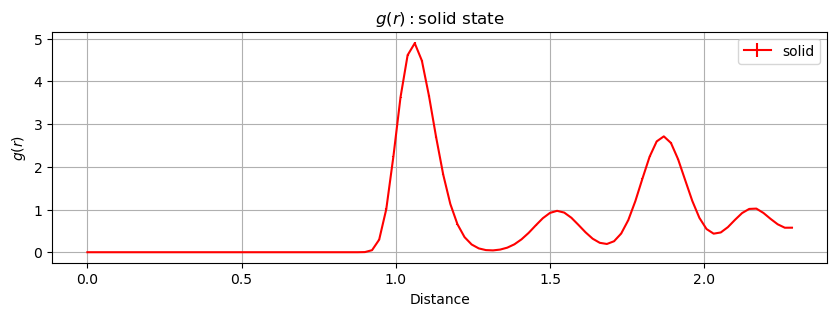

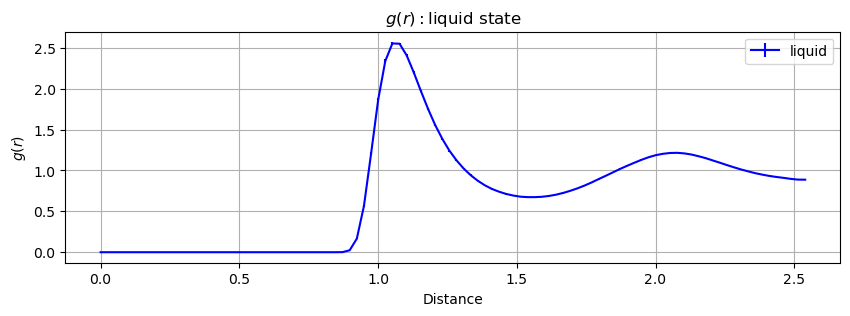

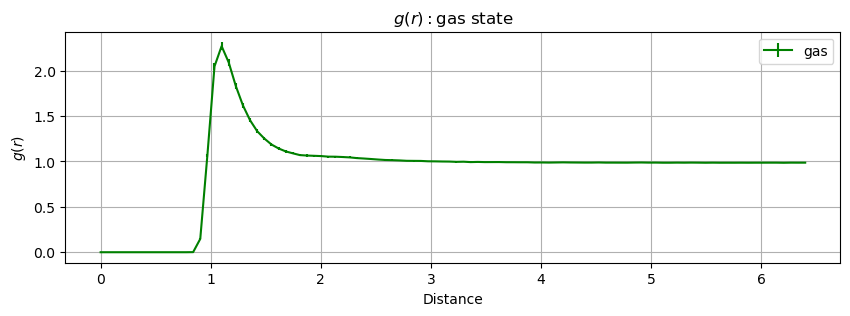

In [7]:
x=np.arange(0,100)

rho = [1.1, 0.8, 0.05]
npart = 108
V = [0.0,0.0,0.0]
for i in range(3):
    V[i] = ((rho[i]/npart)**(-1/3))/200

for i in range(0,3):
    fig=plt.figure(figsize=(10, 3))
    gdr = np.loadtxt("Exercise07-1/output/" + state[i] + "-MC/output_gdr.dat", usecols=range(0,100), unpack='true')
    y = np.mean(gdr, axis=1)
    err = np.std(gdr, axis=1)
    plt.errorbar(x*V[i], y, err, marker='', label=state[i], color = color[i])
    plt.title('$g(r): $' + state[i] + " state")
    plt.ylabel('$g(r)$')
    plt.xlabel('Distance')
    plt.grid(True)
    plt.legend()

plt.show()

Il risultato è coerente con la forma del potenziale di Lennard-Jones, non si trova nessuna particella a distanza $<1$, dove $1$ è stato fissato dalla scelta delle costanti $\epsilon$ e $\sigma$ come il punto dove il potenziale diverge. </br>
Nel caso <i> solido </i> ci sono delle altre distanze a cui è molto probabile trovare particelle, coerentemente con la struttura "a distanza fissata" dei cristalli, e nel caso <i> liquido </i> la presenza di, seppur deboli, legami intramolecolari, fa sì che ci siano ancora distanze più probabili di altre. </br>
Il caso <i> gassoso </i> invece, data l'assenza dei legami, si trova nella condizione per cui ogni distanza oltre quella caratteristica è equivalente, i legami non costringono più le molecole in strutture a distanze preferenziali. </br>
Il grafico contiene anche delle barre d'errore, che si possono notare solamente nel grafico dello stato gassoso, ma sono presenti anche negli altri due.

<a id="ex-7.4"></a>
## Esercizio 7.4. - Confronto simulazioni NVE e NVT
I seguenti grafici mostrano i risultati delle simulazioni MC (nell'ensemble NVT) e MD (nell'ensemble NVE). Le simulazioni del secondo ensemble sono state rifatte con il codice completo di tail corrections e misure dei blocchi calibrate come al punto [7.2](#ex-7.1). </br>
Si nota che le funzioni di distribuzione radiale sono perfettamente compatibili, dunque i due ensemble, pur essendo diversi, raggiungono delle condizioni termodinamiche simili. La stessa compatibilità non viene osservata per le altre due grandezze riportate, $U/N$ e $P$. Questo risultato non è un problema perchè tale compatibilità è ragionevole che sia assente: per quanto si sia tentato di equilibrare la temperatura nel Notebook 4, e l'energia interna in questo Notebook, bisogna comunque considerare che i valori della grandezza non fissata dall'ensemble restano comunque oscillanti. Aver raggiunto delle differenze tra i due valori dell'ordine di grandezza $10^{-1}, 10^{-2}$ è già un risultato sorprendente.

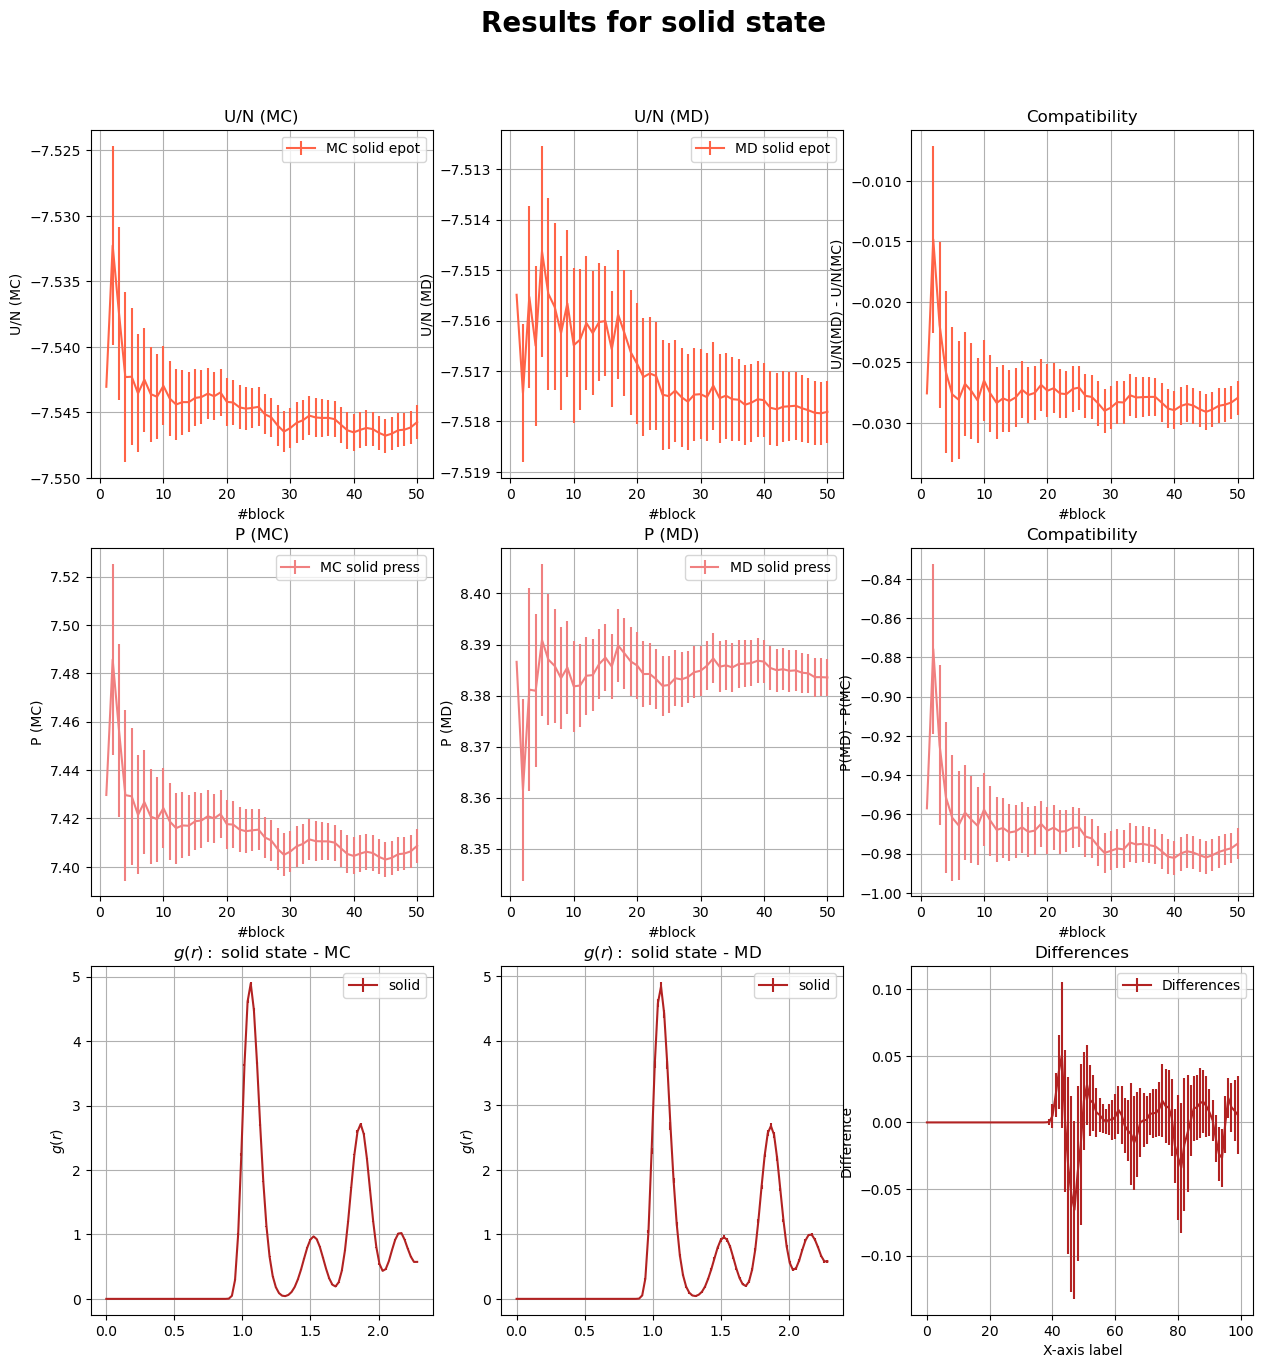

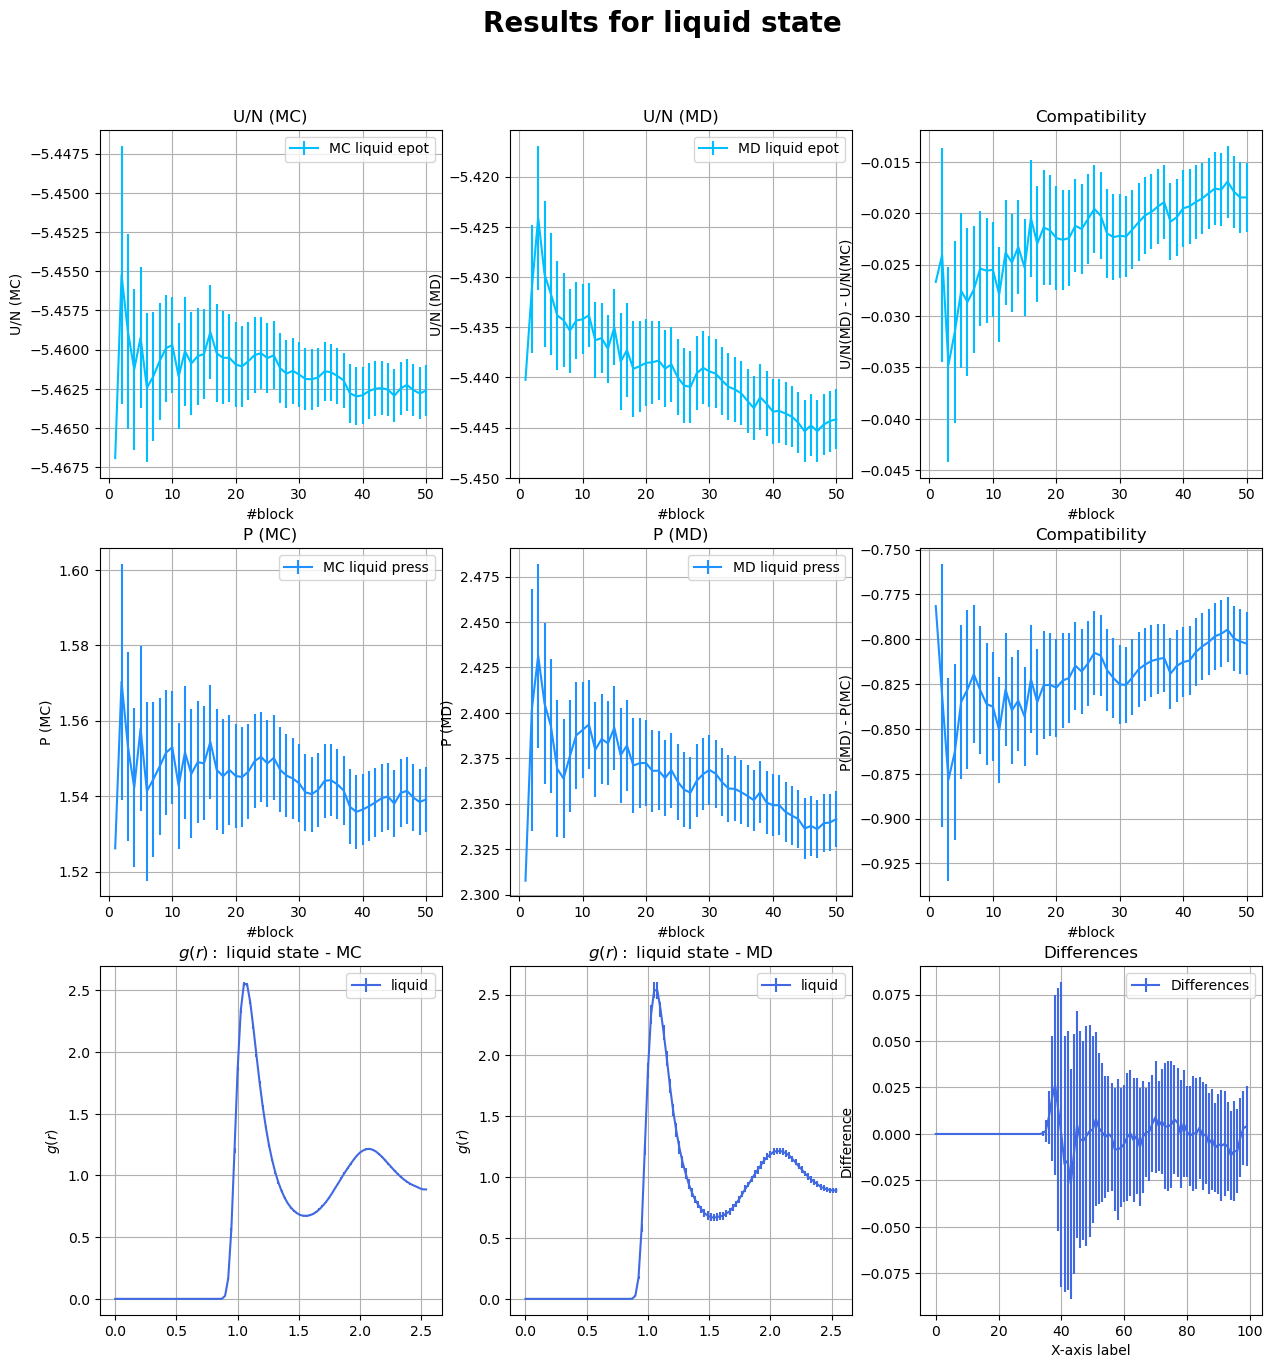

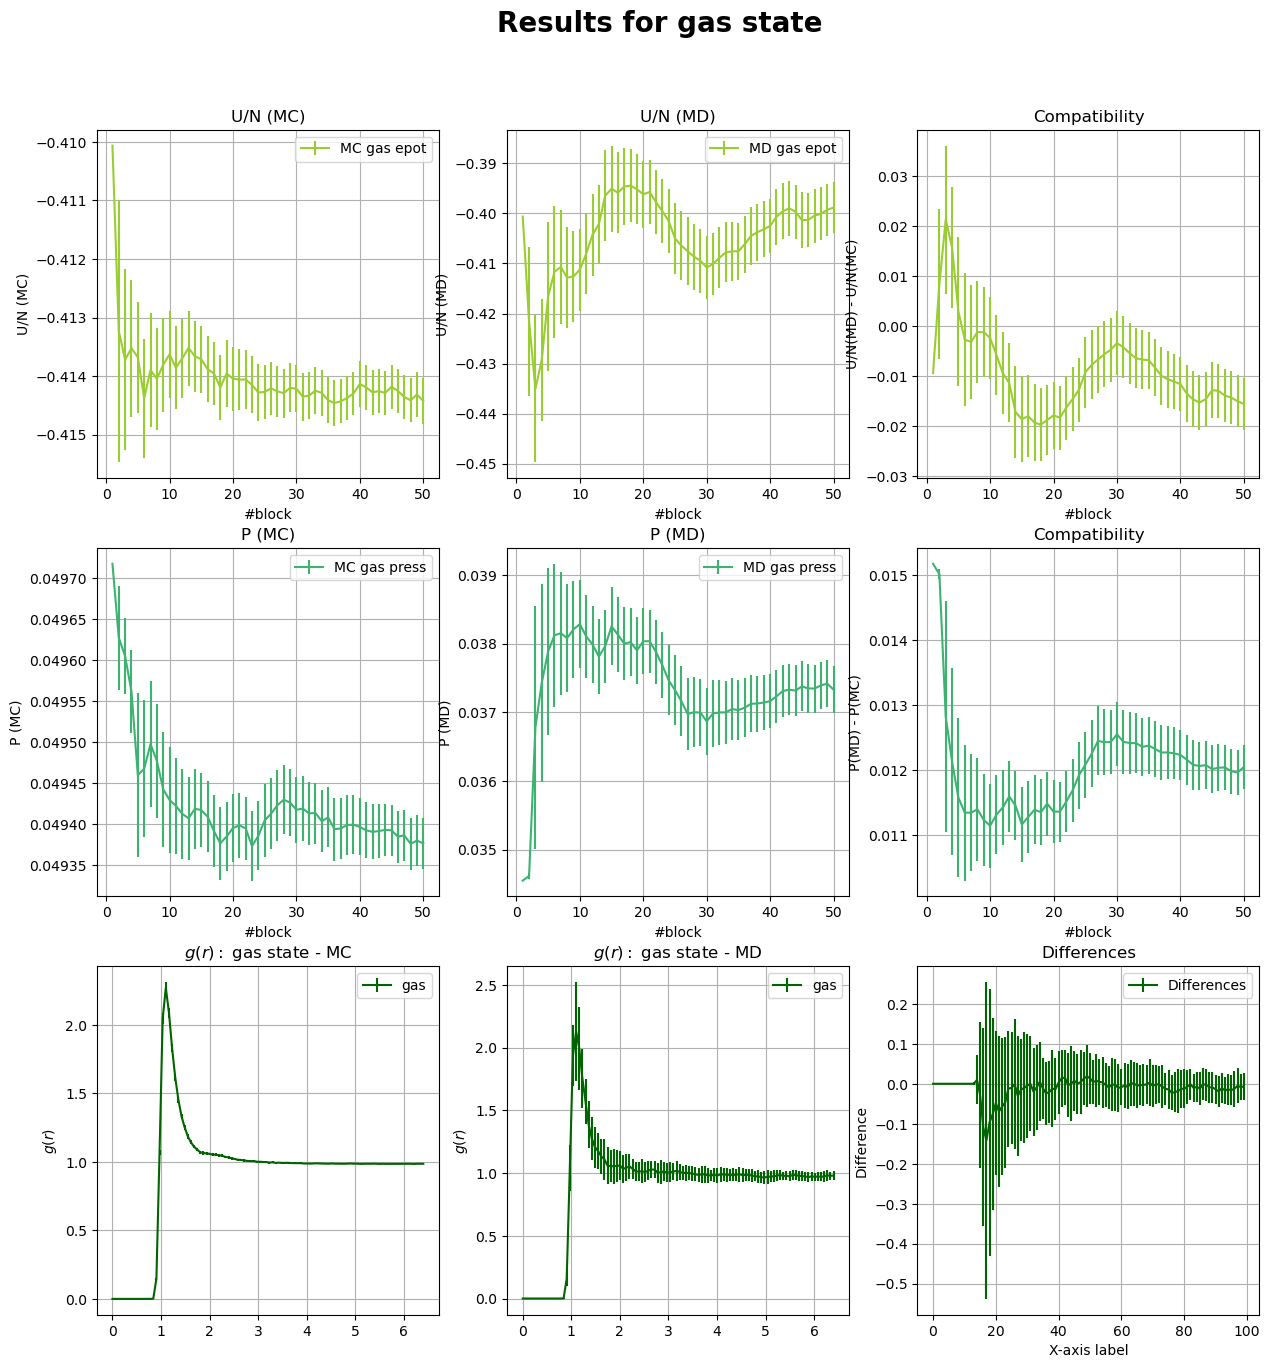

In [8]:
graph = ['epot', 'gdr', 'pres']
index = ['-MC', '-MD']
colors = ['tomato','lightcoral', 'firebrick','deepskyblue','dodgerblue','royalblue','yellowgreen', 'mediumseagreen', 'darkgreen']
k = 0

for j in range(0,3):
    fig, axs = plt.subplots(3, 3, figsize=(15, 15), gridspec_kw={'top': 0.9})
    fig.suptitle('Results for ' + state[j] + ' state', fontsize =20, weight = 'bold')
    #Printing results for potential energy
    x_epotMC, y_epotMC, err_epotMC = np.loadtxt("Exercise07-1/output/" + state[j] + "-MC/output_epot.dat", usecols=(0,2,3), unpack='true')
    axs[0,0].errorbar(x_epotMC, y_epotMC, err_epotMC, color=colors[k], label='MC ' + state[j] + ' epot')
    axs[0, 0].set_xlabel('#block')
    axs[0, 0].set_ylabel('U/N (MC)')
    axs[0, 0].set_title('U/N (MC)')
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    x_epotMD, y_epotMD, err_epotMD = np.loadtxt("Exercise07-1/output/" + state[j] + "-MD/output_epot.dat" , usecols=(0,2,3), unpack='true')
    axs[0,1].errorbar(x_epotMD, y_epotMD, err_epotMD, color=colors[k], label='MD ' + state[j] + ' epot')
    axs[0, 1].set_xlabel('#block')
    axs[0, 1].set_ylabel('U/N (MD)')
    axs[0, 1].set_title('U/N (MD)')
    axs[0, 1].grid(True)
    axs[0, 1].legend()

    axs[0,2].errorbar(x_epotMD, y_epotMC-y_epotMD, np.sqrt(err_epotMC*err_epotMC+err_epotMD*err_epotMD), color=colors[k])
    axs[0, 2].set_xlabel('#block')
    axs[0, 2].set_ylabel('U/N(MD) - U/N(MC)')
    axs[0, 2].set_title('Compatibility')
    axs[0, 2].grid(True)
    k = k+1
    
    #Printing results for pressure
    x_presMC, y_presMC, err_presMC = np.loadtxt("Exercise07-1/output/" + state[j] + "-MC/output_pres.dat", usecols=(0,2,3), unpack='true')
    axs[1,0].errorbar(x_presMC, y_presMC, err_presMC, color=colors[k], label='MC ' + state[j] + ' press')
    axs[1, 0].set_xlabel('#block')
    axs[1, 0].set_ylabel('P (MC)')
    axs[1, 0].set_title('P (MC)')
    axs[1, 0].grid(True)
    axs[1, 0].legend()

    x_presMD, y_presMD, err_presMD = np.loadtxt("Exercise07-1/output/" + state[j] + "-MD/output_pres.dat", usecols=(0,2,3), unpack='true')
    axs[1,1].errorbar(x_presMD, y_presMD, err_presMD, color= colors[k], label='MD ' + state[j] + ' press')
    axs[1, 1].set_xlabel('#block')
    axs[1, 1].set_ylabel('P (MD)')
    axs[1, 1].set_title('P (MD)')
    axs[1, 1].grid(True)
    axs[1, 1].legend()

    axs[1,2].errorbar(x_presMD, y_presMC-y_presMD, np.sqrt(err_presMC*err_presMC+err_presMD*err_presMD), color=colors[k])
    axs[1, 2].set_xlabel('#block')
    axs[1, 2].set_ylabel('P(MD) - P(MC)')
    axs[1, 2].set_title('Compatibility')
    axs[1, 2].grid(True)
    k = k+1
    
    x=np.arange(0,100)
    #Printing results for gr
    gdr_MC = np.loadtxt("Exercise07-1/output/" + state[j] + "-MC/output_gdr.dat",usecols=range(0,100), unpack='true')
    y_MC = np.mean(gdr_MC, axis=1)
    err_MC = np.std(gdr_MC, axis=1)
    axs[2, 0].errorbar(x*V[j], y_MC, err_MC, marker='', label=state[j], color=colors[k])
    axs[2, 0].set_title('$g(r): $ ' + state[j] + ' state - MC')
    axs[2, 0].set_ylabel('$g(r)$')
    axs[2, 0].grid(True)
    axs[2, 0].legend()

    gdr_MD = np.loadtxt("Exercise07-1/output/" + state[j] + "-MD/output_gdr.dat", usecols=range(0,100), unpack='true')
    y_MD = np.mean(gdr_MD, axis=1)
    err_MD = np.std(gdr_MD, axis=1)
    axs[2, 1].errorbar(x*V[j], y_MD, err_MD, marker='', label=state[j], color=colors[k])
    axs[2, 1].set_title('$g(r): $ ' + state[j] + ' state - MD')
    axs[2, 1].set_ylabel('$g(r)$')
    axs[2, 1].grid(True)
    axs[2, 1].legend()
    
    diff = y_MD - y_MC
    err = np.sqrt(err_MD**2 + err_MC**2)

    axs[2, 2].errorbar(x, diff, err, color=colors[k], label='Differences')
    axs[2, 2].set_xlabel('X-axis label')
    axs[2, 2].set_ylabel('Difference')
    axs[2, 2].set_title('Differences')
    axs[2, 2].grid(True)
    axs[2, 2].legend()
    k = k+1


plt.show()